<!-- https://github.com/annegaelle-sng/marketing_ab_testing/blob/main/marketing_ab_testing.ipynb  -->
<div style='margin: 12px auto 12px 37%; font-size: 23px; padding: 12px'>A/B тестирование</div>

<div style='text-indent: 2em; padding: 21px; border: 3px solid  #BEE9F1; width: 533px; margin: auto;'> Использем данные анонимной компании, проанализируем влияние внедрения на целевую страницу веб-сайта новой функции. Тест проводился в течении двух недель. Сейчас компания пытается определить, какую стратегию принять:
</div><br>

- A. Сохранить эту новую функцию  

- B. Оставить старую версию сайта

In [1]:
# Импорт библиотек 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from dataprep.clean import clean_headers
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from dataprep.clean import clean_headers

import warnings
warnings.filterwarnings('ignore')

/var/folders/9_/ll5ms3kn1cvgh7ng385rxvq40000gn/T/ipykernel_20383/1956555708.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport



<p>Описание набора данных:</p>
<ul>
<li><code>Date</code> - дата</li>
<li><code>Spend [USD]</code> - сумма денег, потраченная на рекламу</li>
<li><code># of Impressions</code> - количество людей, просмотревших объявление (неуникальные).</li>
<li><code>Reach</code> - количество пользователей, которые увидели рекламу. 
<li><code># of Website Clicks</code> - количество пользователей, которые перешли по ссылке на веб-сайт. </li>
<li><code># of Searches</code> - количество пользователей, выполнивших поиск на веб-сайте.</li>
<li><code># of View Content</code> -  количество пользователей, которые просмотрели информацию о продукте.</li>
<li><code># of Add to Cart</code> -  количество пользователей, которые добавили товар в корзину.</li>
<li><code># of Purchase</code> -  количество пользователей, которые приобрели продукт.</li>
</ul>

			

In [2]:
# Читаем файлы 
control_data = pd.read_csv('datasets/control.csv').iloc[:,1:]
test_data = pd.read_csv('datasets/test.csv').iloc[:,1:]

In [3]:
control_data.sample(3)

Date  Spend [USD]  # of Impressions    Reach  # of Website Clicks  \
26  27.08.2019         2061          104678.0  91579.0               4941.0   
20  21.08.2019         1803           74654.0  59873.0               5691.0   
0    1.08.2019         2280           82702.0  56930.0               7016.0   

    # of Searches  # of View Content  # of Add to Cart  # of Purchase  
26         3549.0             3249.0             980.0          605.0  
20         2711.0             2496.0            1460.0          800.0  
0          2290.0             2159.0            1819.0          618.0

### Подготовка данных
В первую очередь мы исследуем данные. Имеется два набора данных, равных по количеству: контрольная, тестовая группы.

Проведём общий анализ. 

In [4]:
original_report = ProfileReport(control_data, title="Контрольная группа")
transformed_report = ProfileReport(test_data, title="Тестовая группа")
original_report.compare(transformed_report)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Корректируем имена столбцов 
control_data = clean_headers(control_data, replace={'# ': '', 'of': ''})
test_data = clean_headers(test_data, replace={'# ': '', 'of': ''})

control_data['company'] = 'Контрольная группа'
test_data['company'] = 'Тестовая группа'

Column Headers Cleaning Report:
	9 values cleaned (100.0%)
Column Headers Cleaning Report:
	9 values cleaned (100.0%)


In [6]:
# Объединим таблицы
complete = control_data.merge(test_data, how='outer').sort_values(['date']).reset_index(drop= True)

In [7]:
#  получи дату из значений, от сортируем 
complete['date'] = pd.to_datetime(complete['date'])

complete.sort_values(by=['date'], inplace=True)

In [8]:
#  получим строки с отсутствующими значениями 
complete[complete.isnull().any(axis= 1)]

date  spend_usd  impressions  reach  website_clicks  searches  \
51 2019-05-08       1835          NaN    NaN             NaN       NaN   

    view_content  add_to_cart  purchase             company  
51           NaN          NaN       NaN  Контрольная группа

In [9]:
# Так как все отсутствующие значения находится в одной строке, удалим эту строку 
complete.dropna(inplace=True)

In [10]:
complete.sample(3)

date  spend_usd  impressions    reach  website_clicks  searches  \
1  2019-01-08       3008      39550.0  35820.0          3038.0    1946.0   
52 2019-06-08       2458      42684.0  31489.0          7488.0    1854.0   
23 2019-02-08       2542     100719.0  91236.0          4657.0    2359.0   

    view_content  add_to_cart  purchase          company  
1         1069.0        894.0     255.0  Тестовая группа  
52        1073.0        882.0     488.0  Тестовая группа  
23        1548.0        879.0     677.0  Тестовая группа


### Метрики

In [11]:
# Количество в группах (кол.дней)
complete.groupby(["company"])["company"].count()

company
Контрольная группа    29
Тестовая группа       30
Name: company, dtype: int64

In [12]:
# Общее количество, кто просмотрел рекламу 
people_reach = complete.groupby(["company"])["reach"].sum()
people_reach_count = pd.concat([people_reach, 
               people_reach / people_reach.sum()] , keys=('Количество','Процент'), axis=1)
people_reach_count

Количество   Процент
company                                 
Контрольная группа   2576503.0  0.616204
Тестовая группа      1604747.0  0.383796

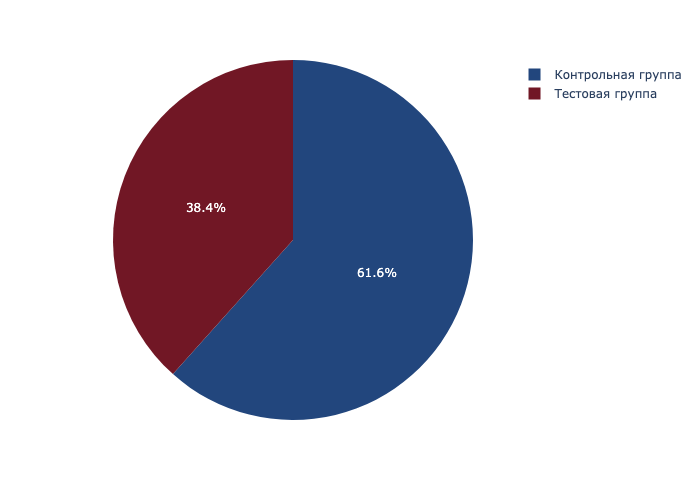

In [13]:
# Построим график 
fig = px.pie(complete, values='reach', names='company', color_discrete_sequence=['#22467D', '#711725'] )
fig.show('png')

Наблюдаем дисбаланс в группах A/B тестирования. 38% людей находятся в контрольной группе и 61% в тестовой. Это существенная разница, что может повлиять на результаты A/B теста. 

Изучим различные показатели.

In [14]:
box0 = px.box(complete, x = "company", y="website_clicks", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])
box1 = px.box(complete, x = "company", y="searches", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])
box2 = px.box(complete, x = "company", y="view_content", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])
box3 = px.box(complete, x = "company", y="add_to_cart", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])
box4 = px.box(complete, x = "company", y="purchase", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])

In [15]:
fig = make_subplots(rows=3, cols=2, subplot_titles=("Переход по ссылке на веб-сайт", "Поиск на веб-сайте", 
                                                    "Просмотр информации о продукте", "Добавлении товара в корзину", 
                                                    "Приобретение товара"))

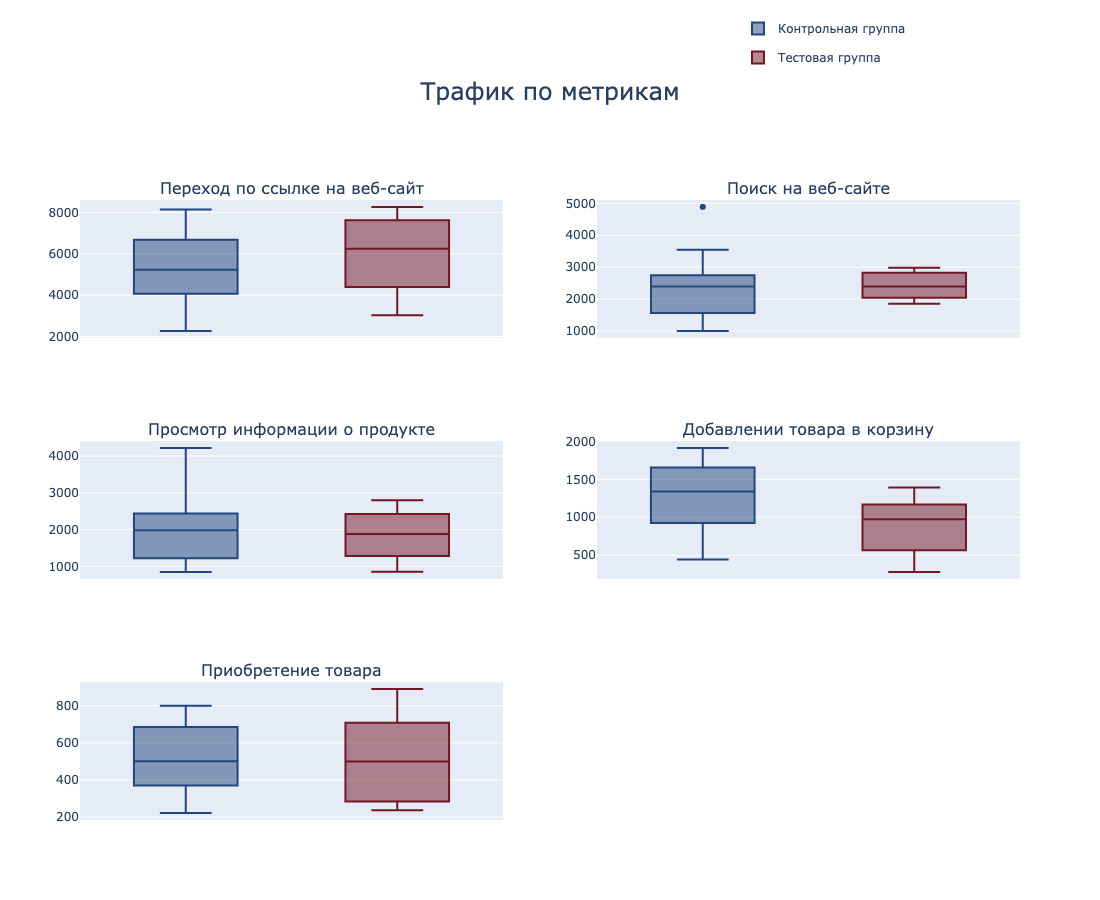

In [16]:
fig.append_trace(box0['data'][0], row=1, col=1)
fig.append_trace(box0['data'][1], row=1, col=1)
fig.append_trace(box1['data'][0], row=1, col=2)
fig.append_trace(box1['data'][1], row=1, col=2)
fig.append_trace(box2['data'][0], row=2, col=1)
fig.append_trace(box2['data'][1], row=2, col=1)
fig.append_trace(box3['data'][0], row=2, col=2)
fig.append_trace(box3['data'][1], row=2, col=2)
fig.append_trace(box4['data'][0], row=3, col=1)
fig.append_trace(box4['data'][1], row=3, col=1)


names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))


fig.update_layout(legend=dict(
                            yanchor="top", 
                            y=1.3, 
                            xanchor="left", 
                            x=0.7), 
                  title=dict(
                      text="Трафик по метрикам ",
                      font=dict(size=24),
                      x=0.5),
                height=900, width=1100, xaxis_visible=False, xaxis2_visible=False, 
                xaxis3_visible=False, xaxis4_visible=False, xaxis5_visible=False)


fig.update_layout(margin=dict(t=200))

fig.show('png')

In [17]:
complete.groupby('company')\
["website_clicks","searches", "view_content", "add_to_cart", "purchase"].mean()

website_clicks     searches  view_content  add_to_cart  \
company                                                                      
Контрольная группа     5320.793103  2221.310345   1943.793103  1300.000000   
Тестовая группа        6032.333333  2418.966667   1858.000000   881.533333   

                      purchase  
company                         
Контрольная группа  522.793103  
Тестовая группа     521.233333

Мы наблюдаем, что контрольная и тестовая группы по-разному влияют на пользователей веб-сайта. Основные различия заключаются в количестве  добавления товара в корзину. В среднем контрольная группа генерирует 1300 пополнений корзины, что на **32 % больше**, чем в тестовой группе.  Само приобретение покупки тоже имеет разницу. Контрольная группа на **1,5% больше** тестовой группы. 

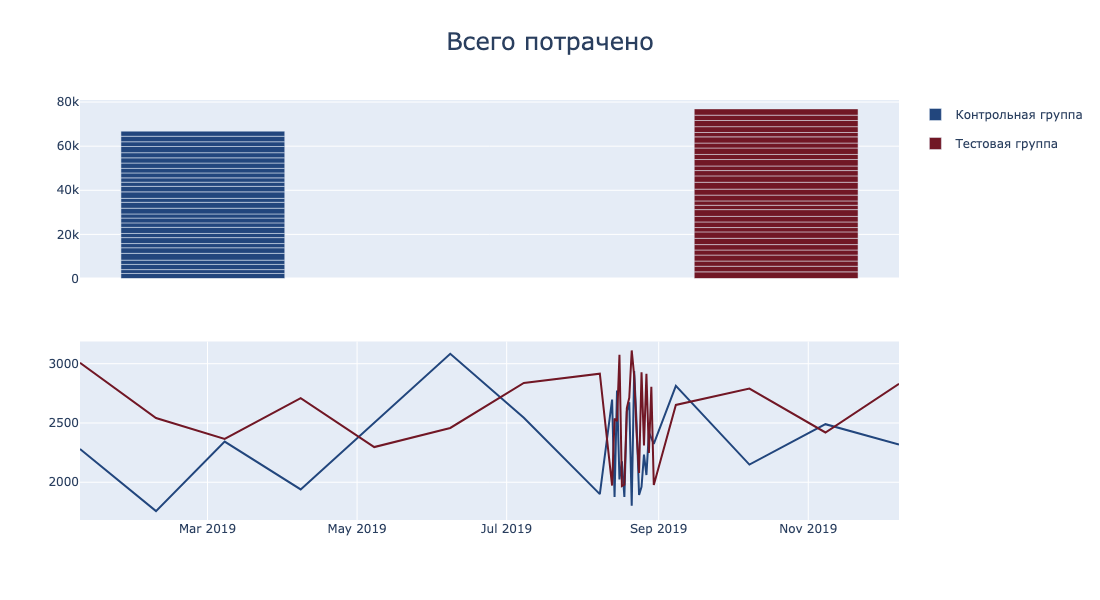

In [18]:
fig = make_subplots(rows=2, cols=1)
trace0 = px.bar(complete, x="company", y="spend_usd",
                color="company", hover_data=['spend_usd'], color_discrete_sequence=['#22467D', '#711725'])
trace1 = px.line(complete, x='date', y='spend_usd', color='company', color_discrete_sequence=['#22467D', '#711725'])

fig.append_trace(trace0['data'][0], row=1, col=1)
fig.append_trace(trace0['data'][1], row=1, col=1)
fig.append_trace(trace1['data'][0], row=2, col=1)
fig.append_trace(trace1['data'][1], row=2, col=1)
fig.update_layout(height=600, width=1100, title=dict(
        text="Всего потрачено",
        font=dict(size=24),
        x=0.5
    ))

fig.update_layout(xaxis_visible=False)
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))


fig.show('png')

Компания потратила деньги на добавление функционала на сайт и проведение А/В тестирования, но действительно ли новый элемент на сайте позволит увеличить доход?

Посмотрим на корреляцию между расходами и другими показателями.

In [19]:
cont_corr_data = complete[complete['company']=='Контрольная группа'].corr()[['spend_usd']]\
    .sort_values(by='spend_usd').round(2)
test_corr_data = complete[complete['company']=='Тестовая группа'].corr()[['spend_usd']]\
    .sort_values(by='spend_usd').round(2)

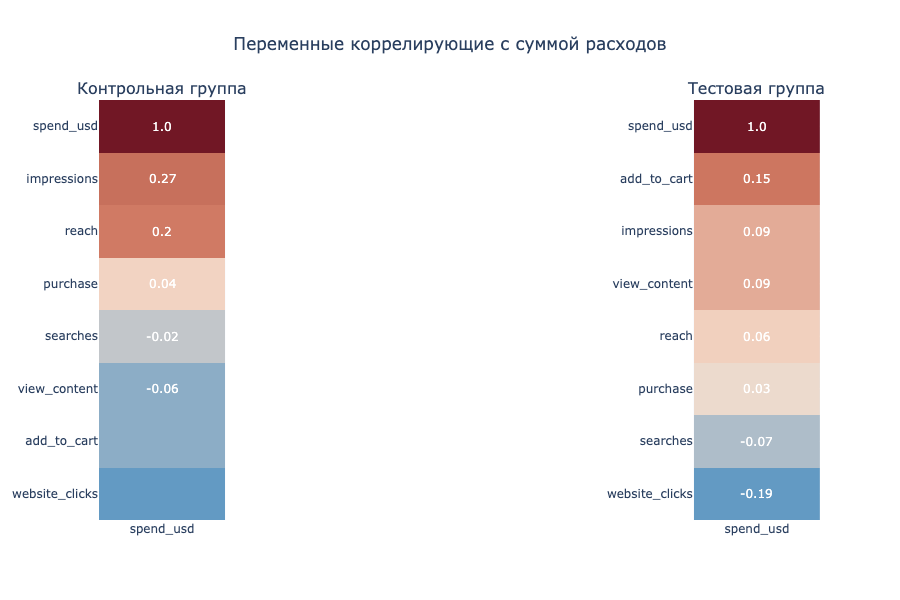

In [20]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.65, subplot_titles=("Контрольная группа", "Тестовая группа"))
fig1 = ff.create_annotated_heatmap(x=cont_corr_data.columns.to_list(), y=cont_corr_data.index.to_list(), \
                                   z=cont_corr_data.values, colorscale=[[0, "#22467D"],
                                                                        [0, "#639AC3"],
                                                                        [0, "#639AC3"],
                                                                        [0.1, "#F7DFCE"],
                                                                        [0.27, "#CF7861"],
                                                                        [1, "#711725"]], hoverinfo='z')
fig2 = ff.create_annotated_heatmap(x=test_corr_data.columns.to_list(), y=test_corr_data.index.to_list(), \
                                   z=test_corr_data.values, colorscale=[[0, "#22467D"],
                                                                        [0, "#639AC3"],
                                                                        [0.000001, "#639AC3"],
                                                                        [0.2, "#F7DFCE"],
                                                                        [0.27, "#CF7861"],
                                                                        [1, "#711725"]],  hoverinfo='z')

fig.add_trace(fig1.data[0], 1, 1)
fig.add_trace(fig2.data[0], 1, 2)

annot1 = list(fig1.layout.annotations)
annot2 = list(fig2.layout.annotations)

for k in range(len(annot2)):
    annot2[k]['xref'] = 'x2'
    annot2[k]['yref'] = 'y2'

fig.update_layout(annotations=annot1+annot2, height=600, width=500)
fig.update_layout(height=600, width=900, title=dict(
        text="Переменные коррелирующие с суммой расходов",
        x=0.5
    ))
fig.show('png')

Между расходами и поведением клиента весомой корреляции не наблюдается. Мы наблюдаем:
 - положительную взаимосвязь между количеством показов и потраченными деньгами (в случае контрольной версии сайта)
 - незначительное положительное влияние на количество людей, добавляющих товары в свою корзину покупок (тестовая группа) 
 - отрицательная корреляция между количеством кликов и расходами (тестовая группа).

 **Затраты на привлечение клиентов**

Рассчитаем стоимость привлечения клиента (CAC)

In [21]:
# CAC
complete.groupby('company')['spend_usd'].sum() / complete.groupby('company')['purchase'].sum()

company
Контрольная группа    4.407229
Тестовая группа       4.917312
dtype: float64

Затраты на получение клиента довольно схожи для обеих групп.
Далее сосредоточимся на таких показателях, как  рэйтинг клиента и коэффициент конверсии.

 ###  Показатель кликабельности
 
 В этом разделе мы сосредоточимся исключительно на CTR, чтобы определить, какую из двух групп рассматривать наиболее эффективной в соответствии с этим показателем.

In [22]:
complete['ctr'] = complete["website_clicks"] / complete["impressions"]

In [23]:
complete.groupby('company')['ctr'].mean()

company
Контрольная группа    0.050959
Тестовая группа       0.102423
Name: ctr, dtype: float64

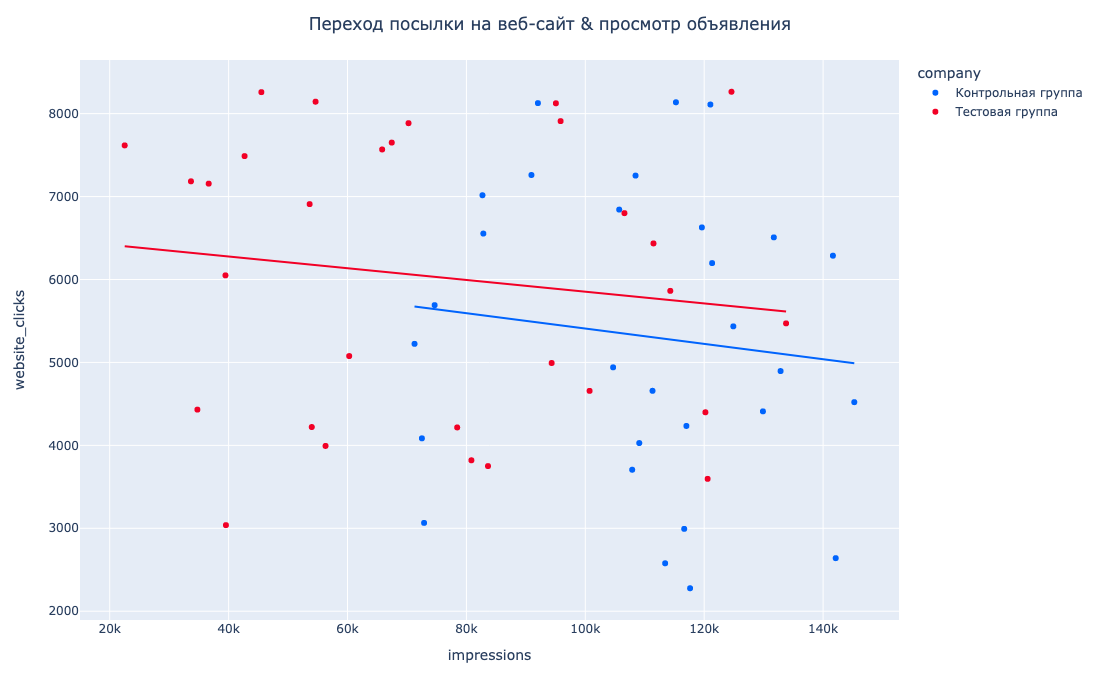

In [24]:
fig=px.scatter(complete, x= 'impressions', y = 'website_clicks',
                      color = 'company', color_discrete_sequence=['#0064FD', '#F20026'],
                      trendline = 'ols')
fig.update_layout(height=700, width=1100, title=dict(
        text="Переход посылки на веб-сайт & просмотр объявления ",
        x=0.5
    ))

fig.show('png')

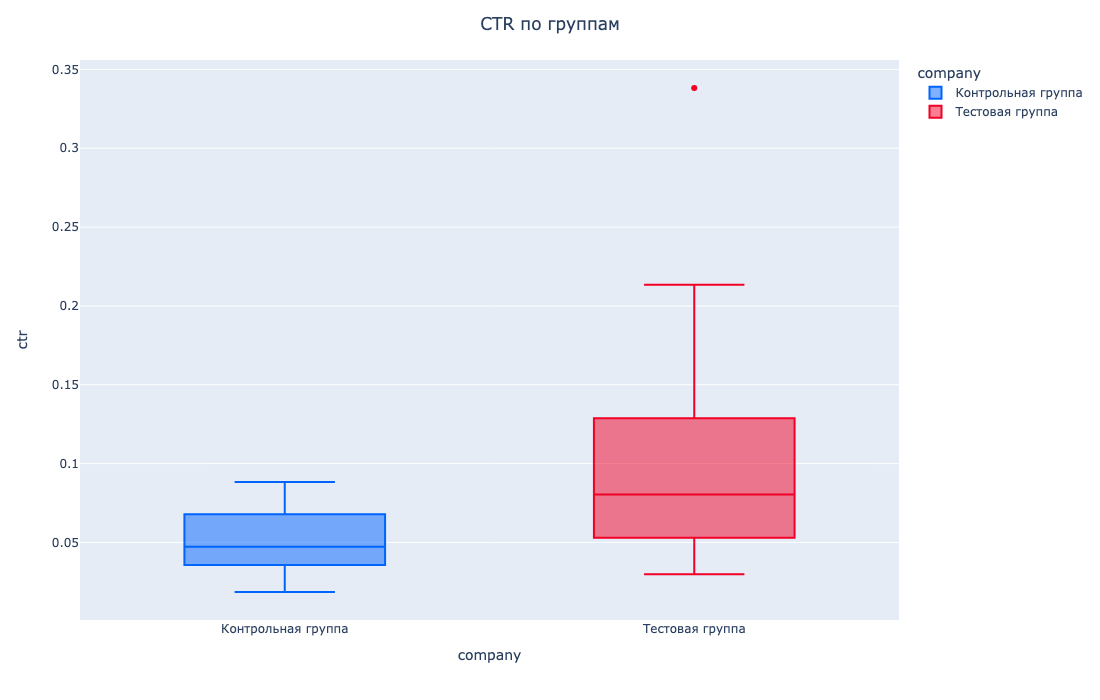

In [25]:
box = px.box(complete, x = "company", y="ctr", color='company', \
              color_discrete_sequence=['#0064FD', '#F20026'])
box.update_layout(height=700, width=1100, title=dict(
        text="CTR по группам",
        x=0.5
    ))

box.show('png')

Наилучший показатель CTR наблюдаем для тестовой группы, в сравнении с контрольной. Убедимся в этом.


#### Проведем бутстрэп-анализ  

In [26]:
boot_ctr = []
for i in range(100000):
    boot_mean = complete.sample(frac=1, replace = True).groupby('company')['ctr'].mean()
    boot_ctr.append(boot_mean)
    
boot_ctr = pd.DataFrame(boot_ctr)

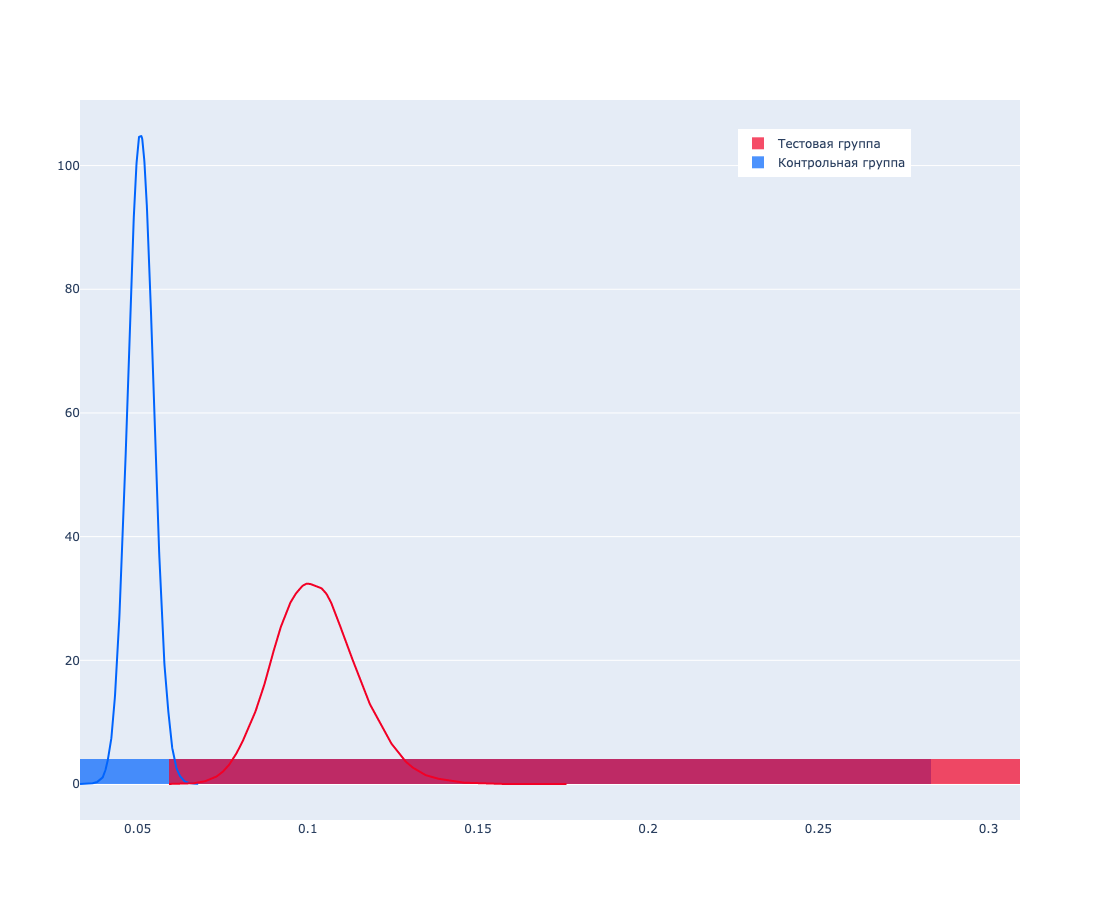

In [29]:
fig = ff.create_distplot([boot_ctr[c] for c in boot_ctr.columns], boot_ctr.columns, colors=['#0064FD', '#F20026'], \
                          show_rug=False, bin_size=.25)
fig.update_layout(legend=dict(
                            yanchor="top", 
                            y=0.96, 
                            xanchor="left", 
                            x=0.7), 
                  height=900, width=1100)
fig.show('png')

Взглянув на сюжет выше **(CTR для каждой группы)**, мы видим некоторую разницу.

In [30]:
# Добавим % разницы между двумя группами и визуализируем ее
boot_ctr['%'] = (boot_ctr['Тестовая группа'] - boot_ctr['Контрольная группа']) / boot_ctr['Контрольная группа']*100

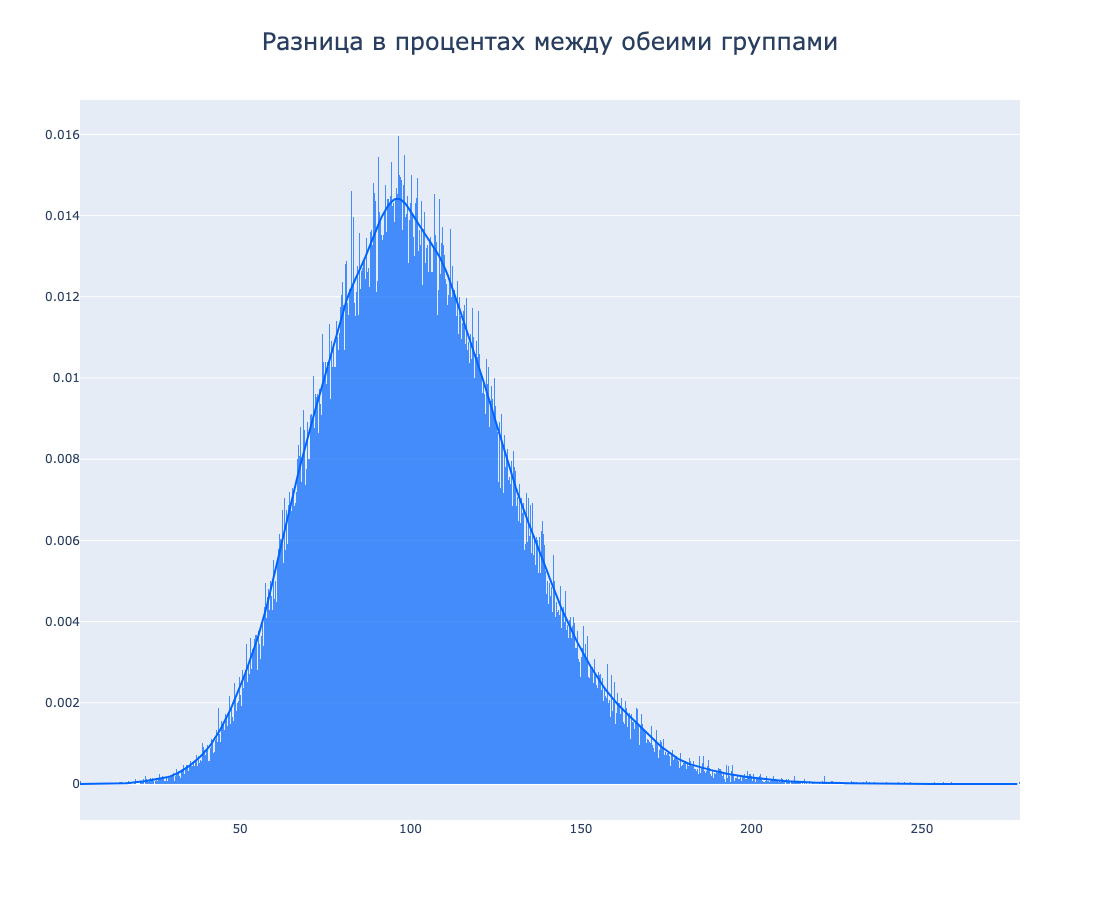

In [31]:
fig = ff.create_distplot([boot_ctr[c] for c in boot_ctr.columns[-1:]], boot_ctr.columns[-1:], colors=['#0064FD', '#F20026'], show_rug=False, bin_size=.25)
fig.update_layout(legend=dict(
                            yanchor="top", 
                            y=0.96, 
                            xanchor="left", 
                            x=0.7), 
                  title=dict(
                            text="Разница в процентах между обеими группами",
                            font=dict(size=24),
                            x=0.5),
                  height=900, width=1100, showlegend=False)
fig.show('png')

In [32]:
# Считаем процент вероятности
prob = (boot_ctr['%'] > 0).mean()

print(f'{prob:.0%} - CTR тестовой группы лучше, чем CTR контрольной группы.')

100% - CTR тестовой группы лучше, чем CTR контрольной группы.



### Коэффициент конверсии
Определим ключевой показатель, который помогает определить эффективность маркетинговых действий на веб-сайте.

In [33]:
complete['conversion_rate'] = complete["purchase"] / complete["reach"]

In [34]:
complete.groupby('company')['conversion_rate'].mean()

company
Контрольная группа    0.006332
Тестовая группа       0.014130
Name: conversion_rate, dtype: float64

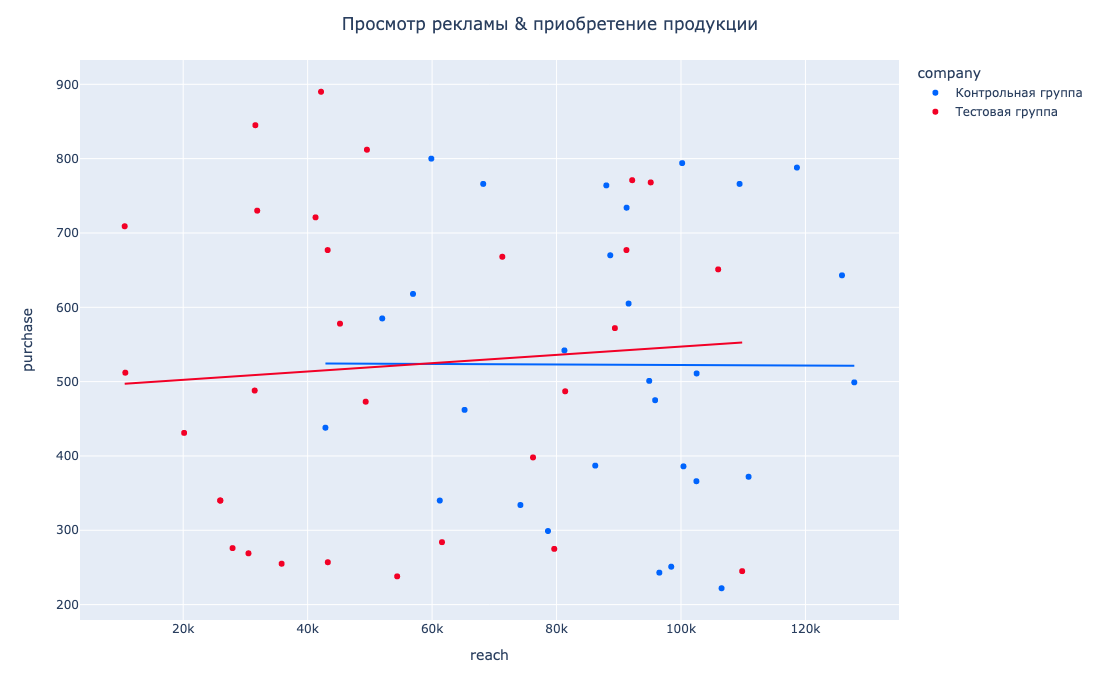

In [35]:
fig=px.scatter(complete, x= 'reach', y = 'purchase',
                      color = 'company', color_discrete_sequence=['#0064FD', '#F20026'],
                      trendline = 'ols')
fig.update_layout(height=700, width=1100, title=dict(
        text="Просмотр рекламы & приобретение продукции",
        x=0.5
    ))

fig.show('png')

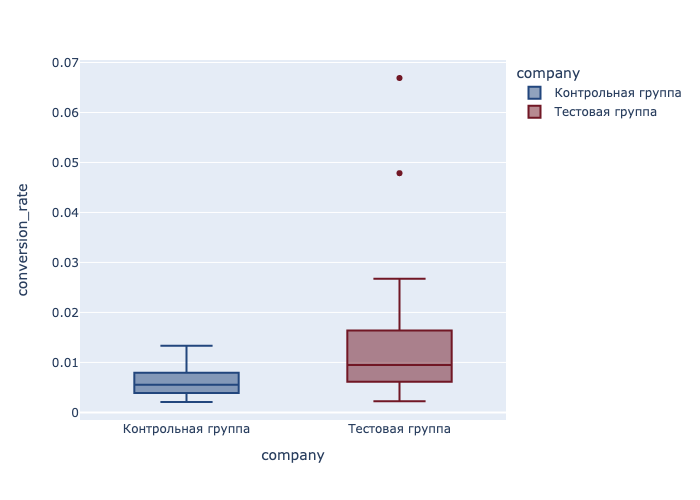

In [36]:
fig = px.box(complete, x = "company", y="conversion_rate", color='company', \
              color_discrete_sequence=['#22467D', '#711725'])
fig.show('png')

Наблюдаем разницу в пользу тестовой группы, относительно CR. Убедимся в этом. 

## Бутстрэп-анализ  

In [37]:
boot_cr = []
for i in range(10000):
    boot_mean = complete.sample(frac=1, replace = True).groupby('company')['conversion_rate'].mean()
    boot_cr.append(boot_mean)
    
boot_cr = pd.DataFrame(boot_cr)

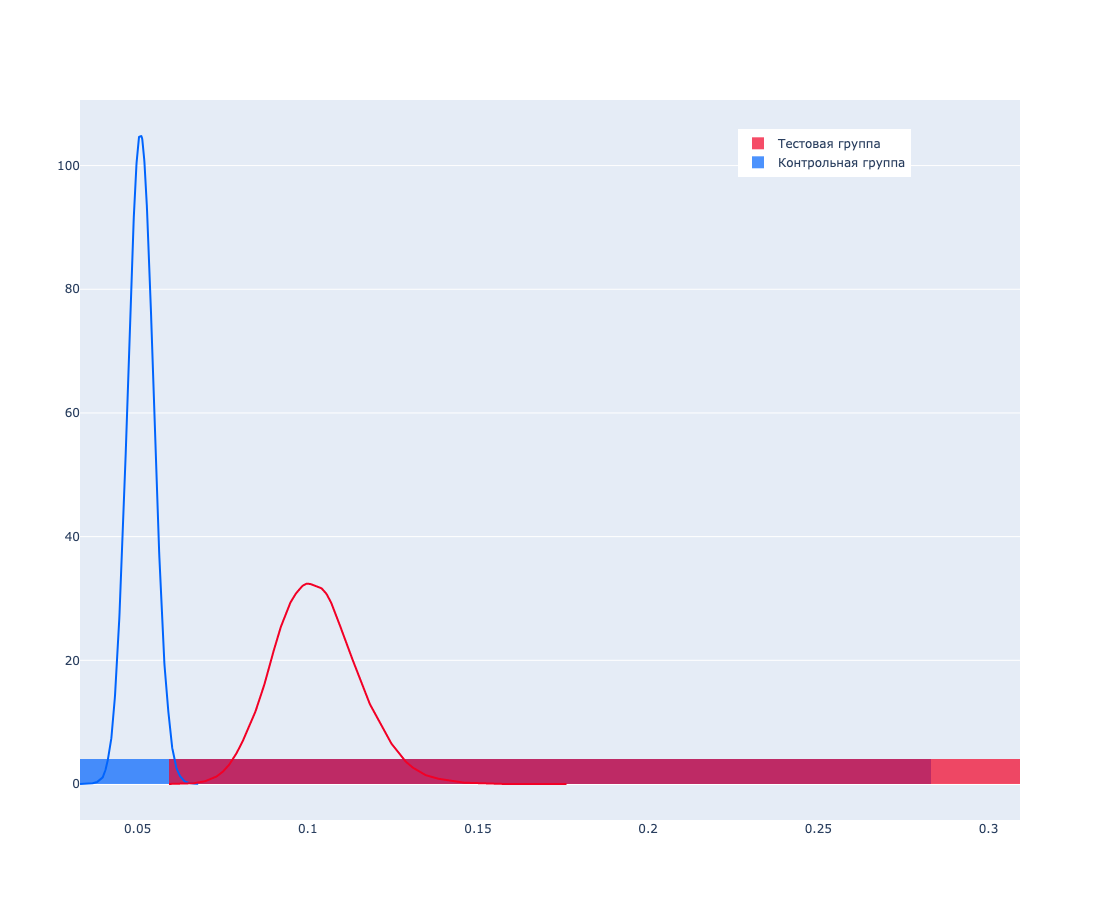

In [38]:
fig = ff.create_distplot([boot_ctr[c] for c in boot_cr.columns], boot_cr.columns, colors=['#0064FD', '#F20026'], show_rug=False, bin_size=.25)
fig.update_layout(legend=dict(
                            yanchor="top", 
                            y=0.96, 
                            xanchor="left", 
                            x=0.7), 
                  height=900, width=1100)
fig.show('png')

Мы наблюдаем весомую разницу, масштабируем ее.

In [39]:
boot_cr['%'] = (boot_cr['Тестовая группа'] - boot_cr['Контрольная группа']) / boot_cr['Контрольная группа'] * 100

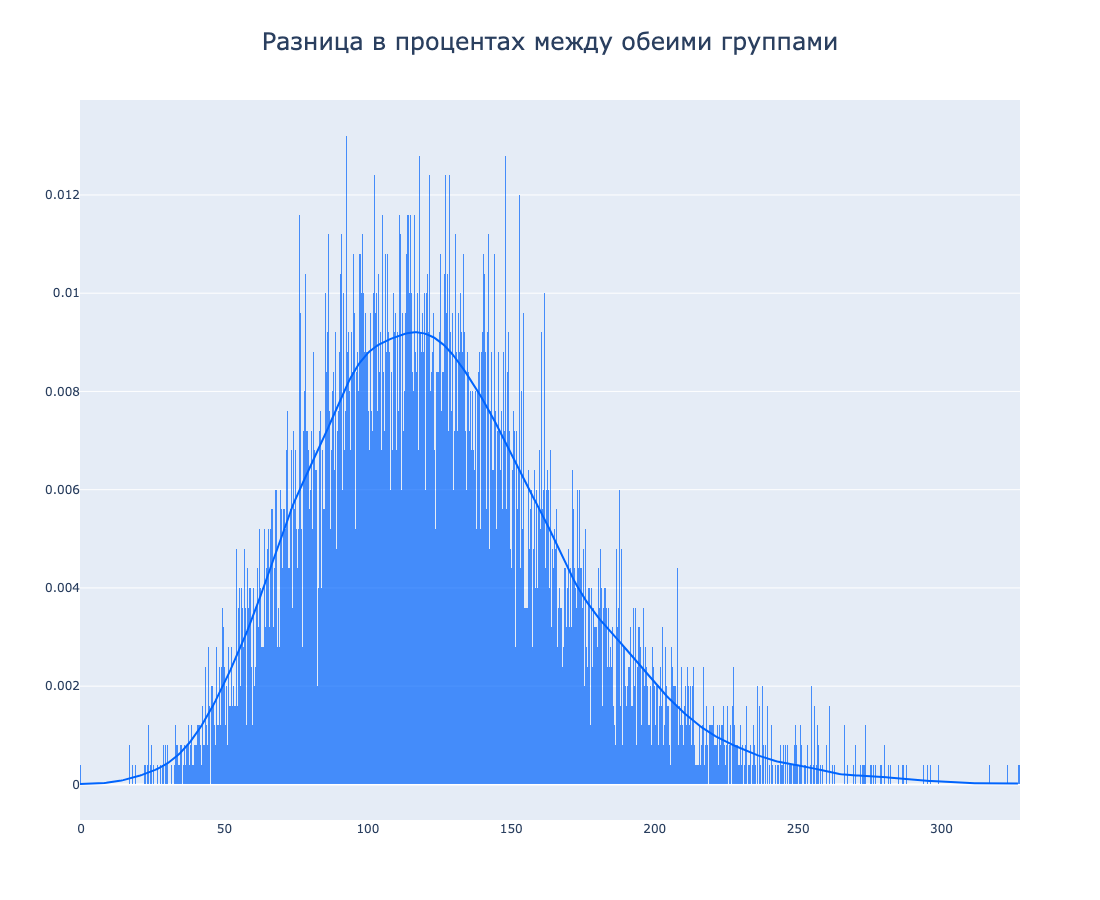

In [40]:
fig = ff.create_distplot([boot_cr[c] for c in boot_ctr.columns[-1:]], boot_ctr.columns[-1:], colors=['#0064FD', '#F20026'], show_rug=False, bin_size=.25)
fig.update_layout(legend=dict(
                            yanchor="top", 
                            y=0.96, 
                            xanchor="left", 
                            x=0.7), 
                  title=dict(
                            text="Разница в процентах между обеими группами",
                            font=dict(size=24),
                            x=0.5),
                  height=900, width=1100, showlegend=False)
fig.show('png')

In [41]:
prob = (boot_cr['%'] > 0).mean()

print(f'{prob:.0%} - коэффициент конверсии тестовый группы лучше, чем CR контрольной группы.')

100% - коэффициент конверсии тестовый группы лучше, чем CR контрольной группы.



---
## Заключение 
Наше A/B-тестирование свидетельствует о том, что тестовая группа ведёт себя очень хорошо по определённым показателям. А именно по количеству переходов на веб-сайт, фактической покупкой. 
Таким образом, **внедрение тестовой группы** представляет собой хорошую стратегию. 

Есть некоторые нюансы. Прежде всего стоимость внедрения этой компании выше. Так же, следует рассмотреть другие показатели, которые здесь не рассматривались, и открыть другие возможности для исследования.